In [16]:
import os
import torch
import pickle
import argparse
import h5py
from torch.autograd import Variable
from model import NetD, NetG
from PIL import Image
import torchvision.transforms as transforms

In [2]:
h = h5py.File('./data/datasets/products/train/data.h5py','r')['train']

In [3]:
for i in h.keys():
    print(i)

asin
cate
docvec


In [4]:
h['asin'][:10]

array([b'0000032069.jpg', b'0000031909.jpg', b'0000032034.jpg',
       b'0000031852.jpg', b'0000031895.jpg', b'0321735722.jpg',
       b'0531904822.jpg', b'059445039X.jpg', b'0594450284.jpg',
       b'060791548X.jpg'], dtype='|S14')

In [5]:
h['cate'][:10]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0]], dtype=int32)

In [110]:
checkpoint_path = 'outputs/netg_checkpoints/netG__epoch_45.pth'

In [111]:
n_z = 100
n_l = 100
n_t = 500
n_c = 64
netG = NetG(n_z=n_z, n_l=n_l, n_c=n_c, n_t=n_t)
netG.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

In [112]:
transform = transforms.Compose([transforms.ToPILImage(),])

In [113]:
netG.zero_grad()

### train sample

In [141]:
index = 3
caption = Variable(torch.from_numpy(h['docvec'][index].reshape(1,-1)))
noise = Variable(torch.randn(1, 100)) # create random noise
noise.data.normal_(0,1) # normalize the noise
fake = netG(noise, caption)

In [142]:
img = transform(fake[0].data)

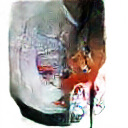

In [143]:
img

### val sample

### test sample

In [17]:
import pandas as pd

In [18]:
df = pd.read_csv('./data/datasets/products/products.tsv',sep='\t',header=None)

In [19]:
df[1].value_counts()

CellPhones&Accessories>Cases>BasicCases                                   222087
CellPhones&Accessories>Accessories>AccessoryKits                           26467
CellPhones&Accessories>Accessories>ScreenProtectors                        15836
CellPhones&Accessories>Accessories>Chargers>CarChargers                     7586
CellPhones&Accessories>Accessories>Chargers>TravelChargers                  6805
CellPhones&Accessories>Accessories>Batteries>InternalBatteries              6637
CellPhones&Accessories>Accessories>DataCables                               6614
CellPhones&Accessories>CellPhones>UnlockedCellPhones                        6262
CellPhones&Accessories>Accessories>ReplacementParts                         6162
CellPhones&Accessories>Accessories>Headsets>BluetoothHeadsets               5009
CellPhones&Accessories>Accessories>Headsets>WiredHeadsets                   5000
CellPhones&Accessories>Accessories>CarAccessories>CarCradles&Mounts         4689
CellPhones&Accessories>Cases